# Capstone Project – The Battle of Neighborhoods | Finding a Better Place in Scarborough, Toronto

In [2]:
!pip install geocoder
!pip install folium

     |████████████████████████████████| 93 kB 3.0 MB/s  eta 0:00:01


Importing Libraries

In [3]:
import pandas as pd
import requests
import numpy as np
import geocoder
import folium
import requests 
import matplotlib.cm as cm
import matplotlib.colors as colors
import json
import xml
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

from pandas.io.json import json_normalize 
from sklearn.cluster import KMeans
from geopy.geocoders import Nominatim 
from bs4 import BeautifulSoup

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

print("All Required Libraries Imported!")

All Required Libraries Imported!


## 2. Data Extraction and Cleaning

Using BeautifulSoup Scraping List of Postal Codes of Given Wikipedia Page. Link: https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M

In [4]:
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
extracting_data = requests.get(url).text
wiki_data = BeautifulSoup(extracting_data, 'lxml')

Converting content of PostalCode HTML table as dataframe

In [5]:
column_names = ['Postalcode','Borough','Neighborhood']
toronto = pd.DataFrame(columns = column_names)

content = wiki_data.find('div', class_='mw-parser-output')
table = content.table.tbody
postcode = 0
borough = 0
neighborhood = 0

for tr in table.find_all('tr'):
    i = 0
    for td in tr.find_all('td'):
        if i == 0:
            postcode = td.text
            i = i + 1
        elif i == 1:
            borough = td.text
            i = i + 1
        elif i == 2: 
            neighborhood = td.text.strip('\n').replace(']','')
    toronto = toronto.append({'Postalcode': postcode,'Borough': borough,'Neighborhood': neighborhood},ignore_index=True)

In [6]:
# clean dataframe 
toronto = toronto[toronto.Borough!='Not assigned']
toronto = toronto[toronto.Borough!= 0]
toronto.reset_index(drop = True, inplace = True)
i = 0
for i in range(0,toronto.shape[0]):
    if toronto.iloc[i][2] == 'Not assigned':
        toronto.iloc[i][2] = toronto.iloc[i][1]
        i = i+1

In [7]:
df = toronto.groupby(['Postalcode','Borough'])['Neighborhood'].apply(', '.join).reset_index()
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [8]:
df.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M2N\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [9]:
df = df.dropna()
empty = 'Not assigned'
df = df[(df.Postalcode != empty ) & (df.Borough != empty) & (df.Neighborhood != empty)]

In [10]:
df.head()

,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [11]:
def neighborhood_list(grouped):    
    return ', '.join(sorted(grouped['Neighborhood'].tolist()))
                    
grp = df.groupby(['Postalcode', 'Borough'])
df_2 = grp.apply(neighborhood_list).reset_index(name='Neighborhood')

In [12]:
df_2.describe()

,Postalcode,Borough,Neighborhood
count,180,180,180
unique,180,11,100
top,M2N\n,Not assigned\n,Not assigned\n
freq,1,77,77


In [13]:
print(df_2.shape)
df_2.head()

(180, 3)


,Postalcode,Borough,Neighborhood
0,M1A\n,Not assigned\n,Not assigned\n
1,M1B\n,Scarborough\n,"Malvern, Rouge"
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek"
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill"
4,M1G\n,Scarborough\n,Woburn


In [14]:

def get_latilong(postal_code):
    lati_long_coords = None
    while(lati_long_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(postal_code))
        lati_long_coords = g.latlng
    return lati_long_coords
    
get_latilong('M4G')

[43.709020000000066, -79.36348999999996]

In [15]:
# Retrieving Postal Code Co-ordinates
postal_codes = df_2['Postalcode']    
coords = [ get_latilong(postal_code) for postal_code in postal_codes.tolist() ]

In [16]:
# Adding Columns Latitude & Longitude
df_coords = pd.DataFrame(coords, columns=['Latitude', 'Longitude'])
df_2['Latitude'] = df_coords['Latitude']
df_2['Longitude'] = df_coords['Longitude']

In [20]:
df_2[df_2.Postalcode == 'M5G']

,Postalcode,Borough,Neighborhood,Latitude,Longitude


In [19]:
df_2.head(10)

,Postalcode,Borough,Neighborhood,Latitude,Longitude
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761
5,M1H\n,Scarborough\n,Cedarbrae,43.76944,-79.23892
6,M1J\n,Scarborough\n,Scarborough Village,43.74446,-79.23117
7,M1K\n,Scarborough\n,"Kennedy Park, Ionview, East Birchmount Park",43.72582,-79.26461
8,M1L\n,Scarborough\n,"Golden Mile, Clairlea, Oakridge",43.71289,-79.28506
9,M1M\n,Scarborough\n,"Cliffside, Cliffcrest, Scarborough Village West",43.72360,-79.23496


In [32]:
#pip install geopy
from geopy.geocoders import Nominatim

In [34]:

address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent=address)
location = geolocator.geocode(address)
latitude_x = location.latitude
longitude_y = location.longitude
print('The Geograpical Co-ordinate of Scarborough,Toronto are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Scarborough,Toronto are 43.7729744, -79.2576479.


## 3. Map of Scarborough

In [35]:
map_Scarborough = folium.Map(location=[latitude_x, longitude_y], zoom_start=10)

for lat, lng, nei in zip(df_2['Latitude'], df_2['Longitude'], df_2['Neighborhood']):
    
    label = '{}'.format(nei)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_Scarborough)  
    
map_Scarborough

In [38]:
address = 'Scarborough,Toronto'

geolocator = Nominatim(user_agent=address)
location = geolocator.geocode(address)
latitude_n1 = location.latitude
longitude_n1 = location.longitude
print('The Geograpical Co-ordinate of Neighborhood_1 are {}, {}.'.format(latitude_x, longitude_y))

The Geograpical Co-ordinate of Neighborhood_1 are 43.7729744, -79.2576479.


In [39]:
# @hiddel_cell
CLIENT_ID = 'YM4BEHZC1M4ER2MAWZGEEYGG0NQ4IA43WETGE3EYJJJLIEM' # my Foursquare ID
CLIENT_SECRET = 'MZ1WZS5B5CVZ3OUWQIGOQIADRRYDY12KVCYFECUKJGC5UK0V' # my Foursquare Secret
VERSION = '20180604'
LIMIT = 30
print('Your credentails:')
print('CLIENT_ID: '+CLIENT_ID)
print('CLIENT_SECRET: '+CLIENT_SECRET)

Your credentails:
CLIENT_ID: YM4BEHZC1M4ER2MAWZGEEYGG0NQ4IA43WETGE3EYJJJLIEM
CLIENT_SECRET: MZ1WZS5B5CVZ3OUWQIGOQIADRRYDY12KVCYFECUKJGC5UK0V


In [82]:
radius = 700 
LIMIT = 100
url = 'https://api.foursquare.com/v2/venues/explore?&client_id=YYM4BEHZC1M4ER2MAWZGEEYGG0NQ4IA43WETGE3EYJJJLIEM&client_secret=MZ1WZS5B5CVZ3OUWQIGOQIADRRYDY12KVCYFECUKJGC5UK0V&ll=43.7729744,-79.2576479&v=20180604&radius=500&limit=30'
#url = 'https://api.foursquare.com/v2/venues/search?client_id=YYM4BEHZC1M4ER2MAWZGEEYGG0NQ4IA43WETGE3EYJJJLIEM&client_secret=MZ1WZS5B5CVZ3OUWQIGOQIADRRYDY12KVCYFECUKJGC5UK0V&ll=40.7149555,-74.0153365&v=20180604&query=Italian&radius=500&limit=30'
url
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fd84b0abac16900661127af'},
 'response': {'headerLocation': 'Scarborough City Centre',
  'headerFullLocation': 'Scarborough City Centre, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 42,
  'suggestedBounds': {'ne': {'lat': 43.777474404500005,
    'lng': -79.25142759021877},
   'sw': {'lat': 43.7684743955, 'lng': -79.26386820978122}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c059bcd7083952134097bce',
       'name': 'SEPHORA',
       'location': {'address': '300 Borough Drive',
        'crossStreet': 'at Scarborough Town Centre',
        'lat': 43.77501688366838,
        'lng': -79.25810909472256,
        'labeledLatLngs': [{'label': 'display',
          'lat': 43.77501688366838,
          'lng': -79

In [83]:
venues=results['response']['groups'][0]['items']
#venues=results
#venues=results['response'][0]
nearby_venues = json_normalize(venues)
nearby_venues.columns

Index(['referralId', 'reasons.count', 'reasons.items', 'venue.id',
       'venue.name', 'venue.location.address', 'venue.location.crossStreet',
       'venue.location.lat', 'venue.location.lng',
       'venue.location.labeledLatLngs', 'venue.location.distance',
       'venue.location.postalCode', 'venue.location.cc', 'venue.location.city',
       'venue.location.state', 'venue.location.country',
       'venue.location.formattedAddress', 'venue.categories',
       'venue.photos.count', 'venue.photos.groups',
       'venue.location.neighborhood', 'venue.venuePage.id'],
      dtype='object')

In [84]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

## 4. Nearby Venues/Locations

In [85]:
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]
nearby_venues.head()

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,SEPHORA,"[{'id': '4bf58dd8d48988d10c951735', 'name': 'C...",43.775017,-79.258109
1,Disney Store,"[{'id': '4bf58dd8d48988d1f3941735', 'name': 'T...",43.775537,-79.256833
2,American Eagle Store,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776012,-79.258334
3,St. Andrews Fish & Chips,"[{'id': '4edd64a0c7ddd24ca188df1a', 'name': 'F...",43.771865,-79.252645
4,Tommy Hilfiger,"[{'id': '4bf58dd8d48988d103951735', 'name': 'C...",43.776015,-79.257369


## 5. Categories of Nearby Venues/Locations

In [86]:
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head(5)

,name,categories,lat,lng
0,SEPHORA,Cosmetics Shop,43.775017,-79.258109
1,Disney Store,Toy / Game Store,43.775537,-79.256833
2,American Eagle Store,Clothing Store,43.776012,-79.258334
3,St. Andrews Fish & Chips,Fish & Chips Shop,43.771865,-79.252645
4,Tommy Hilfiger,Clothing Store,43.776015,-79.257369


In [87]:
# Top 10 Categories
a=pd.Series(nearby_venues.categories)
a.value_counts()[:10]

Clothing Store        6
Sandwich Place        2
Department Store      2
Gas Station           1
Smoothie Shop         1
Coffee Shop           1
Cosmetics Shop        1
Bank                  1
Mexican Restaurant    1
Pharmacy              1
Name: categories, dtype: int64

In [93]:
def getNearbyVenues(names, latitudes, longitudes, radius=700):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # making GET request
        venue_results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in venue_results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [94]:
Scarborough_venues = getNearbyVenues(names=df_2['Neighborhood'],
                                   latitudes=df_2['Latitude'],
                                   longitudes=df_2['Longitude']
                                  )

Not assigned

Malvern, Rouge
Rouge Hill, Port Union, Highland Creek
Guildwood, Morningside, West Hill
Woburn
Cedarbrae
Scarborough Village
Kennedy Park, Ionview, East Birchmount Park
Golden Mile, Clairlea, Oakridge
Cliffside, Cliffcrest, Scarborough Village West
Birch Cliff, Cliffside West
Dorset Park, Wexford Heights, Scarborough Town Centre
Wexford, Maryvale
Agincourt
Clarks Corners, Tam O'Shanter, Sullivan
Milliken, Agincourt North, Steeles East, L'Amoreaux East
Steeles West, L'Amoreaux West
Upper Rouge
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Hillcrest Village
Fairview, Henry Farm, Oriole
Bayview Village
York Mills, Silver Hills
Willowdale, Newtonbrook
Willowdale, Willowdale East
York Mills West
Willowdale, Willowdale West
Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Not assigned

Parkwoods
Don Mills
Don Mills
Not assigned

Not assigned

Bathurst Manor, Wilson Heights, Downsview North
No

In [96]:
print('There are {} Uniques Categories.'.format(len(Scarborough_venues['Venue Category'].unique())))
Scarborough_venues.groupby('Neighborhood').count().head()

There are 23 Uniques Categories.


,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Agincourt,30,30,30,30,30,30
"Alderwood, Long Branch",30,30,30,30,30,30
"Bathurst Manor, Wilson Heights, Downsview North",30,30,30,30,30,30
Bayview Village,30,30,30,30,30,30
"Bedford Park, Lawrence Manor East",30,30,30,30,30,30


One Hot Encoding of Features

In [97]:
# one hot encoding
Scarborough_onehot = pd.get_dummies(Scarborough_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
Scarborough_onehot['Neighborhood'] = Scarborough_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [Scarborough_onehot.columns[-1]] + list(Scarborough_onehot.columns[:-1])
Scarborough_onehot = Scarborough_onehot[fixed_columns]
Scarborough_grouped = Scarborough_onehot.groupby('Neighborhood').mean().reset_index()
Scarborough_onehot.head(5)

,Neighborhood,American Restaurant,Bakery,Bank,Bar,Clothing Store,Coffee Shop,Cosmetics Shop,Department Store,Fish & Chips Shop,Food Court,Gas Station,Greek Restaurant,Gym,Mexican Restaurant,Movie Theater,Pharmacy,Sandwich Place,Shopping Mall,Smoothie Shop,Sporting Goods Shop,Tea Room,Toy / Game Store,Video Game Store
0,Not assigned\n,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Not assigned\n,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,Not assigned\n,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Not assigned\n,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Not assigned\n,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [101]:
num_top_venues = 5
for hood in Scarborough_grouped['Neighborhood']:
    print("---- "+hood+" ----")
    temp =Scarborough_grouped[Scarborough_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

---- Agincourt ----
                 venue  freq
0       Clothing Store  0.20
1     Department Store  0.07
2       Sandwich Place  0.07
3  American Restaurant  0.03
4   Mexican Restaurant  0.03


---- Alderwood, Long Branch ----
                 venue  freq
0       Clothing Store  0.20
1     Department Store  0.07
2       Sandwich Place  0.07
3  American Restaurant  0.03
4   Mexican Restaurant  0.03


---- Bathurst Manor, Wilson Heights, Downsview North ----
                 venue  freq
0       Clothing Store  0.20
1     Department Store  0.07
2       Sandwich Place  0.07
3  American Restaurant  0.03
4   Mexican Restaurant  0.03


---- Bayview Village ----
                 venue  freq
0       Clothing Store  0.20
1     Department Store  0.07
2       Sandwich Place  0.07
3  American Restaurant  0.03
4   Mexican Restaurant  0.03


---- Bedford Park, Lawrence Manor East ----
                 venue  freq
0       Clothing Store  0.20
1     Department Store  0.07
2       Sandwich Place  0.07

In [102]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

## Most Common venues near neighborhood

In [103]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Scarborough_grouped['Neighborhood']

for ind in np.arange(Scarborough_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Scarborough_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
1,"Alderwood, Long Branch",Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
2,"Bathurst Manor, Wilson Heights, Downsview North",Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
3,Bayview Village,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
4,"Bedford Park, Lawrence Manor East",Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop


## K-Means Clustering Approach

In [104]:
# Using K-Means to cluster neighborhood into 3 clusters
Scarborough_grouped_clustering = Scarborough_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=3, random_state=0).fit(Scarborough_grouped_clustering)
kmeans.labels_

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [105]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Scarborough_merged =df_2.iloc[:16,:]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
Scarborough_merged = Scarborough_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

Scarborough_merged.head()# check the last columns!

,Postalcode,Borough,Neighborhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,M1A\n,Not assigned\n,Not assigned\n,43.64869,-79.38544,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
1,M1B\n,Scarborough\n,"Malvern, Rouge",43.81139,-79.19662,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
2,M1C\n,Scarborough\n,"Rouge Hill, Port Union, Highland Creek",43.78574,-79.15875,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
3,M1E\n,Scarborough\n,"Guildwood, Morningside, West Hill",43.76575,-79.17470,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
4,M1G\n,Scarborough\n,Woburn,43.76812,-79.21761,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop


## Map of Clusters

In [106]:
kclusters = 10

In [107]:
# create map
map_clusters = folium.Map(location=[latitude_x, longitude_y], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
colors_array = cm.rainbow(np.linspace(0, 1, kclusters))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to the map

markers_colors = []
for lat, lon, nei , cluster in zip(Scarborough_merged['Latitude'], 
                                   Scarborough_merged['Longitude'], 
                                   Scarborough_merged['Neighborhood'], 
                                   Scarborough_merged['Cluster Labels']):
    label = folium.Popup(str(nei) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

['#8000ff', '#4856fb', '#10a2f0', '#2adddd', '#62fbc4', '#9cfba4', '#d4dd80', '#ffa256', '#ff562c', '#ff0000']


## Avg House Rent by Cluster

In [151]:
df1=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 0,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df2=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 1,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]
df3=Scarborough_merged.loc[Scarborough_merged['Cluster Labels'] == 2,Scarborough_merged.columns[[2] + list(range(5, Scarborough_merged.shape[1]))]]

In [160]:
Scarborough_Avg_HousingPrice=pd.DataFrame({"Neighborhood":df_2["Neighborhood"],
                                      "Average_Housing_Price":[335000.0,286600.0,175000.0,225900.0,219400.0,
                                                               573900.0,225000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,225000.0,370500.,255400.0,433500.0,433500.0,
                                                               435000.0,289500.0,265000.0,285900.0,239400.0,
                                                               589900.0,295000.0,380500.0,378500.0,438500.0,229200.0,
                                                               229200.0,365000.0,388500.,285400.0,493500.0,477500.0,378000.0,316600.0,195000.0,225900.0,219400.0,
                                                               573900.0,367000.0,370500.0,370500.0,363500.0,279200.0,
                                                               279200.0,271000.0,370500.,255400.0,383500.0,433500.0,335000.0,286600.0,185000.0,225900.0,219400.0,
                                                               573900.0,329000.0,370500.0,370500.0,533500.0,279200.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,
                                                               279200.0,289000.0,370500.,255400.0,413500.0,433500.0,254800.0,
                                                               279200.0,375000.0,370500.,255400.0,493500.0,433500.0,335000.0,286600.0,165000.0,225900.0,219400.0,
                                                               573900.0,425000.0,370500.0,370500.0,433500.0,279200.0,
                                                               279200.0,195000.0,370500.,255400.0,403500.0,433500.0,335000.0,286600.0,187000.0,225900.0,219400.0,
                                                               573900.0,325000.0,370500.0,370500.0,333500.0,279200.0,370500.0,370500.0
                                                              
                                                              
                                                              ]})

In [161]:
Scarborough_Avg_HousingPrice.set_index('Neighborhood',inplace=True,drop=True)

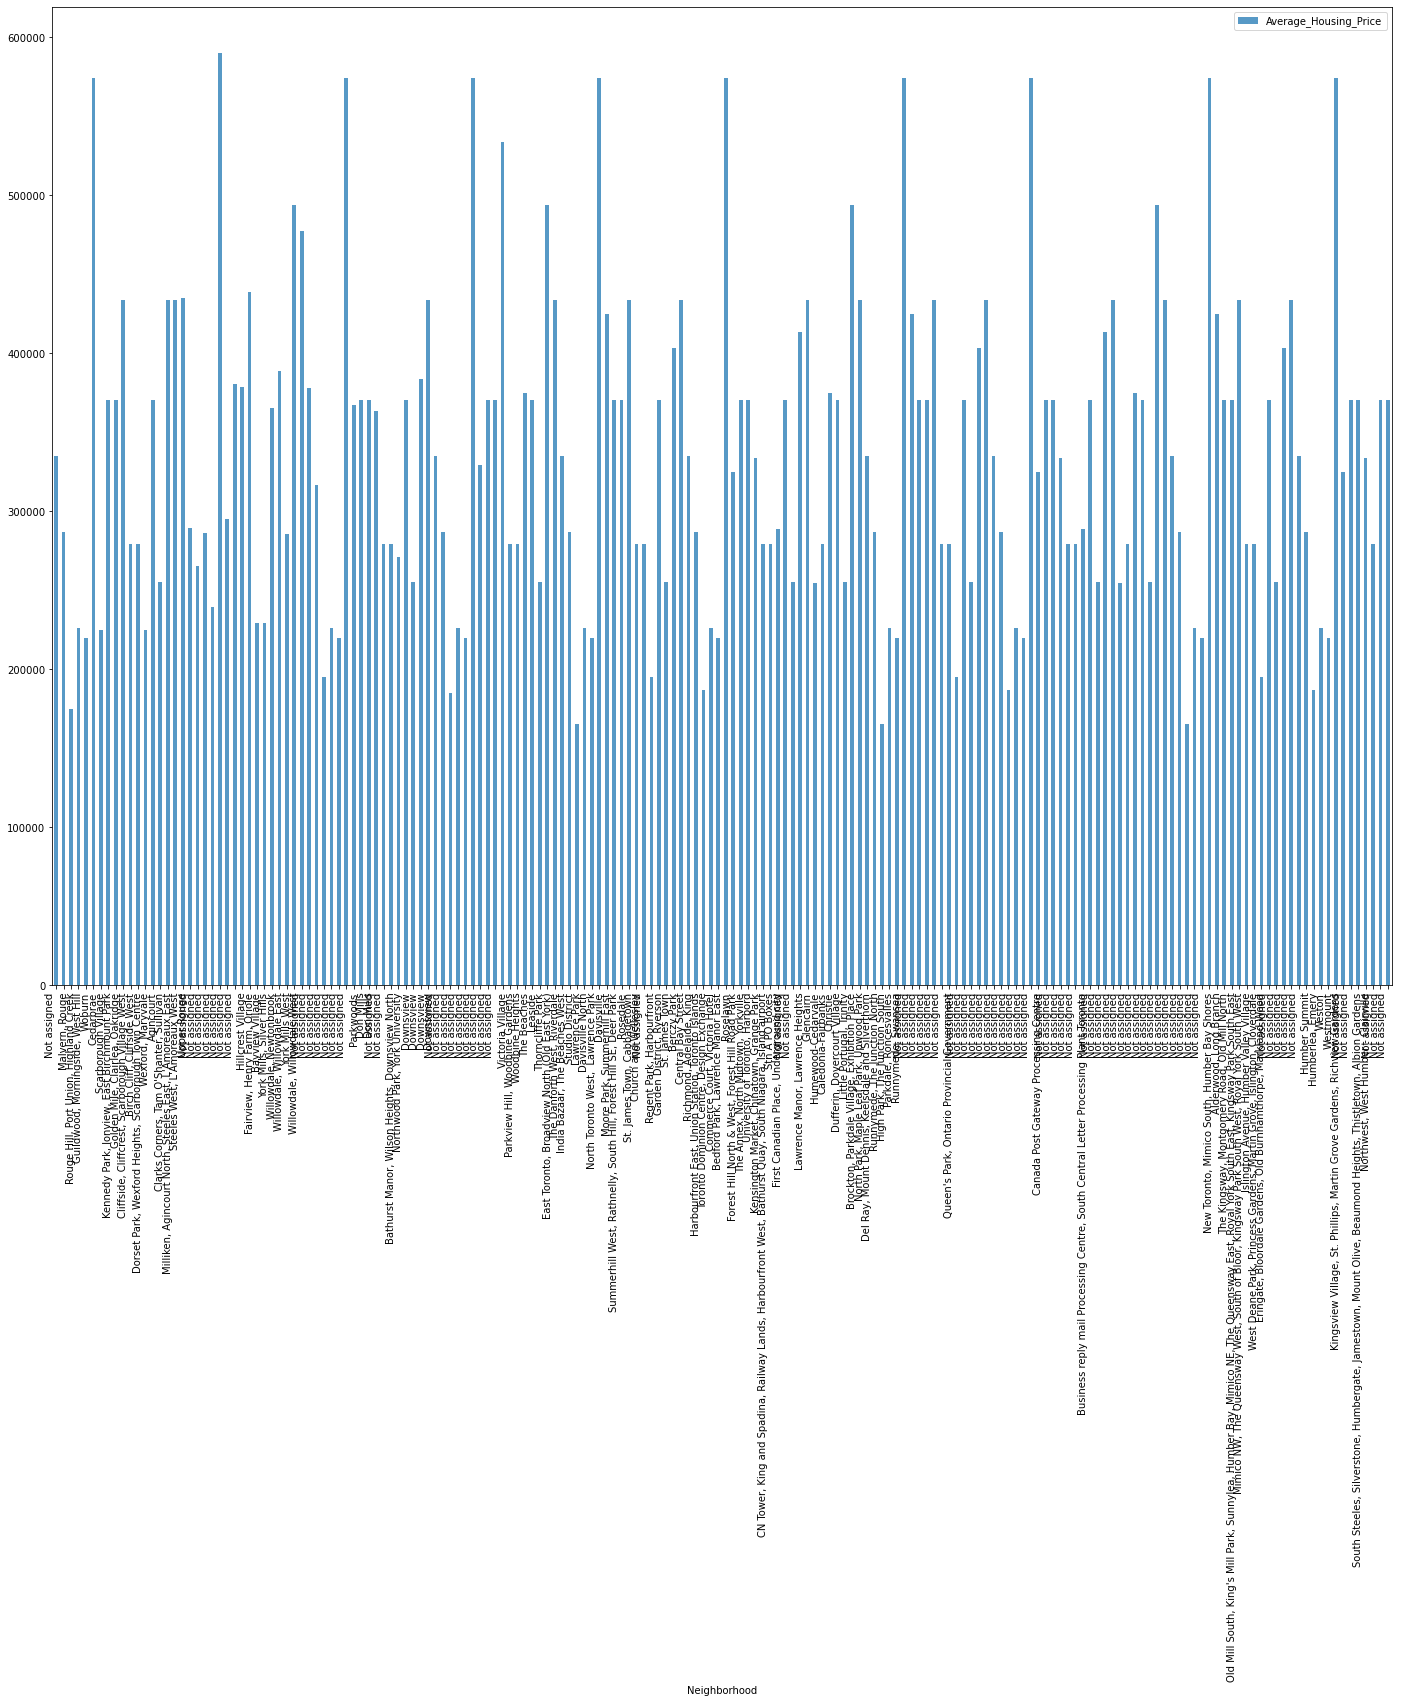

In [162]:
Scarborough_Avg_HousingPrice.plot(kind='bar',figsize=(24,18),alpha=0.75)

## School Rating by Clusters

In [128]:
clusters=pd.DataFrame({"Cluster1":df1["Neighborhood"],
                      "Cluster2":df2["Neighborhood"],
                      "Cluster4":df3["Neighborhood"]})
clusters = clusters.replace(np.nan, '', regex=True)
clusters

,Cluster1,Cluster2,Cluster4
0,Not assigned\n,,
1,"Malvern, Rouge",,
2,"Rouge Hill, Port Union, Highland Creek",,
3,"Guildwood, Morningside, West Hill",,
4,Woburn,,
5,Cedarbrae,,
6,Scarborough Village,,
7,"Kennedy Park, Ionview, East Birchmount Park",,
8,"Golden Mile, Clairlea, Oakridge",,
9,"Cliffside, Cliffcrest, Scarborough Village West",,


In [136]:
#clusters
new_Scarborough=Scarborough_merged.set_index("Neighborhood",drop=True)
#new_Scarborough=Scarborough_merged.reset_index
new_Scarborough

,Postalcode,Borough,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Neighborhood,,,,,,,,,,,,,,,
Not assigned\n,M1A\n,Not assigned\n,43.64869,-79.38544,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
"Malvern, Rouge",M1B\n,Scarborough\n,43.81139,-79.19662,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
"Rouge Hill, Port Union, Highland Creek",M1C\n,Scarborough\n,43.78574,-79.15875,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
"Guildwood, Morningside, West Hill",M1E\n,Scarborough\n,43.76575,-79.17470,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
Woburn,M1G\n,Scarborough\n,43.76812,-79.21761,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
Cedarbrae,M1H\n,Scarborough\n,43.76944,-79.23892,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
Scarborough Village,M1J\n,Scarborough\n,43.74446,-79.23117,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
"Kennedy Park, Ionview, East Birchmount Park",M1K\n,Scarborough\n,43.72582,-79.26461,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop
"Golden Mile, Clairlea, Oakridge",M1L\n,Scarborough\n,43.71289,-79.28506,0,Clothing Store,Sandwich Place,Department Store,Video Game Store,Gas Station,Bakery,Bank,Bar,Coffee Shop,Cosmetics Shop


In [139]:
new_Scarborough.shape

(16, 15)

In [148]:
Scarborough_school_ratings=pd.DataFrame({"Neighborhood":df["Neighborhood"],
                                      "Top School Rating":[7,9,5,8,10,10,7,10,1,2,1,2,7,2,3,2,6,
                                                           5,4,8,9,9,6,6,4,5,4,6,8,10,8,9,6,2,
                                                           10,2,5,8,9,6,6,10,8,9,1,2,3,4,5,6,9,
                                                           8,5,9,6,9,6,4,8,10,2,5,6,3,9,8,7,
                                                           7,8,5,8,9,1,5,4,7,2,3,6,6,9,4,8,7,
                                                           4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           5,10,4,6,8,9,7,5,6,5,8,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                            4,8,9,2,6,4,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                           5,10,4,6,8,9,7,5,6,5,8,7,5,10,4,6,8,9,7,5,6,5,8,7,
                                                            4,8,9,2,6,4,7,6,5,7
                                                           ]})

In [149]:
Scarborough_school_ratings.set_index('Neighborhood',inplace=True,drop=True)

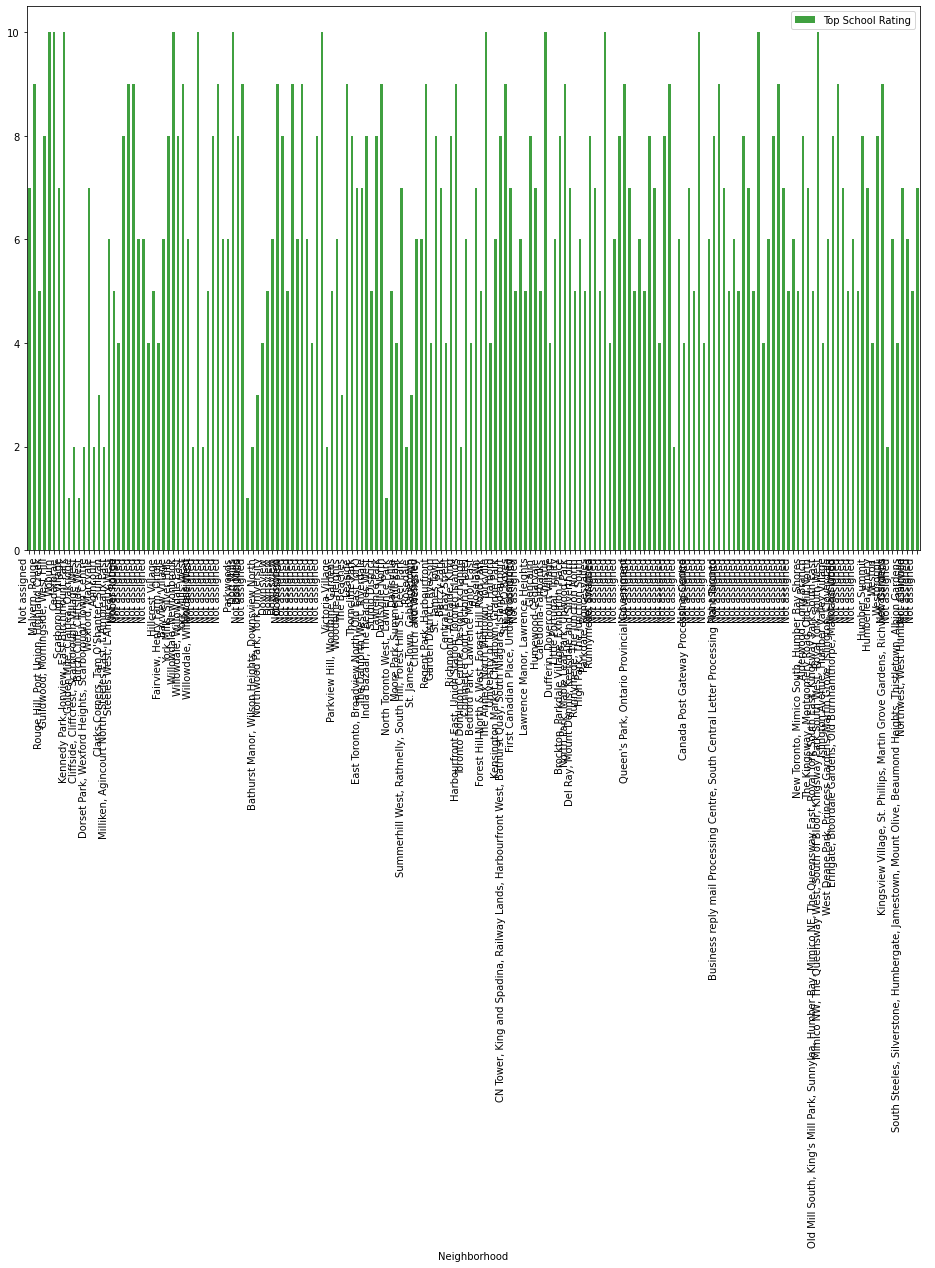

In [150]:
Scarborough_school_ratings.plot(kind='bar',figsize=(16,10),color='green',alpha=0.75);